In [39]:
from src import func1 as f1
from src import linear_program as lp
import pandas as pd
import numpy as np
import importlib
from matplotlib import pyplot as plt
import geopandas as gpd
import svi_data

In [40]:
importlib.reload(f1)
importlib.reload(lp)

<module 'src.linear_program' from 'c:\\Users\\kcall\\OneDrive - Gainwell Technologies\\Documents\\Underserved_otp\\src\\linear_program.py'>

In [41]:
zip_geo_data = f1.load_zip_geo_data('data/zip_shapes/zip_geo_data.shp')
provider_data = f1.load_provider_data()
year_rates_data = f1.load_rates_data()
states_geo_data = f1.load_states_geo_data('data/state_shapes/states_geo_data.shp')
DIST_THRESH = 16

c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:177: DtypeWarning: Columns (12,13,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  rates_data = pd.read_csv('data/prescribing_rates.csv')


In [42]:
importlib.reload(f1)
importlib.reload(lp)

<module 'src.linear_program' from 'c:\\Users\\kcall\\OneDrive - Gainwell Technologies\\Documents\\Underserved_otp\\src\\linear_program.py'>

In [43]:
key = '7ff0bbdbdce6def37dc1ccb38160791e501c1020'

# Download the data from census API
svi_zips = svi_data.get_svi(key,'zip',2019)
svi_zips['ZIP'] = svi_zips['GEO_ID'].str[-5:]

svi_geo = f1.load_zip_geo_data('data/zip_shapes/zip_geo_data.shp')
svi_geo = svi_geo.join(svi_zips.set_index(['ZIP']), on='ZIP', how='left')


SSLError: HTTPSConnectionPool(host='api.census.gov', port=443): Max retries exceeded with url: /data/2019/acs/acs5?get=B27001_005E%2CB17001_001E%2CB16005_012E%2CB16005_035E%2CB25044_010E%2CB25024_001E%2CB25014_011E%2CB27001_014E%2CB16005_039E%2CB18101_026E%2CB27001_020E%2CB01001H_001E%2CB27001_001E%2CB27001_026E%2CB27001_011E%2CB18101_023E%2CB25014_001E%2CB16005_017E%2CB16005_030E%2CB16005_029E%2CB25014_013E%2CB09001_001E%2CB16005_034E%2CB11003_010E%2CB25024_008E%2CB28004_001E%2CB18101_019E%2CB27001_029E%2CB17001_002E%2CB27001_033E%2CB16005_013E%2CB27001_048E%2CB25014_012E%2CB25014_005E%2CB23025_005E%2CB27010_051E%2CB26001_001E%2CB27001_008E%2CB16005_040E%2CB16005_044E%2CB18101_016E%2CB25044_001E%2CB16005_023E%2CB18101_010E%2CB06009_002E%2CB27010_001E%2CB25001_001E%2CB25014_006E%2CB27001_051E%2CGEO_ID&for=zip+code+tabulation+area%3A%2A&key=7ff0bbdbdce6def37dc1ccb38160791e501c1020&in=state%3A%2A (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1129)')))

# West Virginia

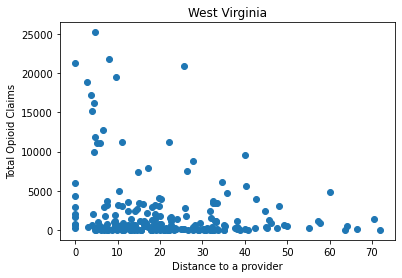

c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:310: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return provider_with_geo['geometry'].centroid


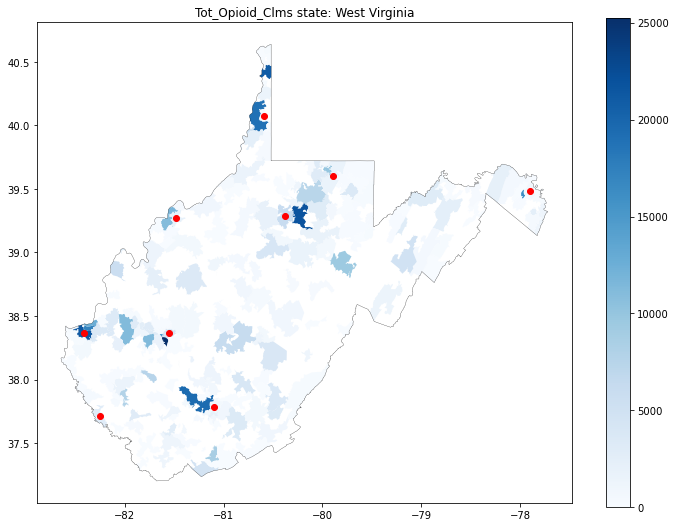

c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:310: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return provider_with_geo['geometry'].centroid


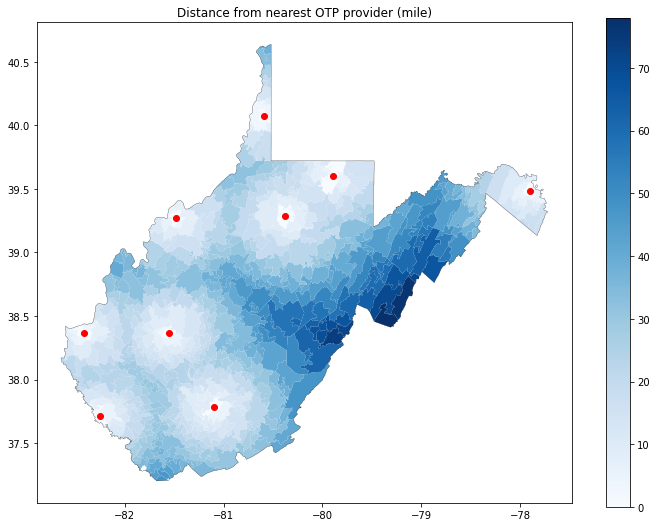

c:\Users\kcall\Miniconda3\lib\site-packages\geopandas\geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\linear_program.py:145: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: ESRI:102008
Right CRS: None

  distances = gpd.GeoSeries(merged['RATES CENTERS']).distance(gpd.GeoSeries(merged['PROVIDER CENTERS']), align=False)


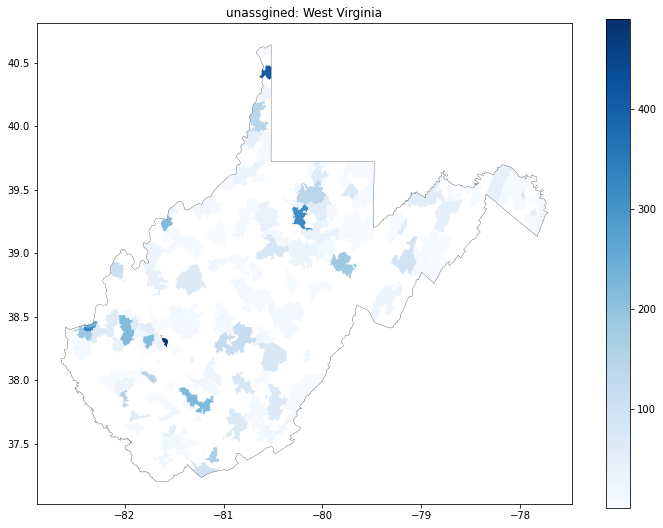

In [ ]:
state = 'West Virginia'
f1.distance_scatter_plot(zip_geo_data, provider_data, year_rates_data, state)
f1.plot_rates(states_geo_data, zip_geo_data, year_rates_data, provider_data, 'Tot_Opioid_Clms', state)
f1.plot_dist_to_providers(zip_geo_data, states_geo_data, provider_data, state)
wv_lp = lp.run_model(provider_data, zip_geo_data, year_rates_data, state, DIST_THRESH, True)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


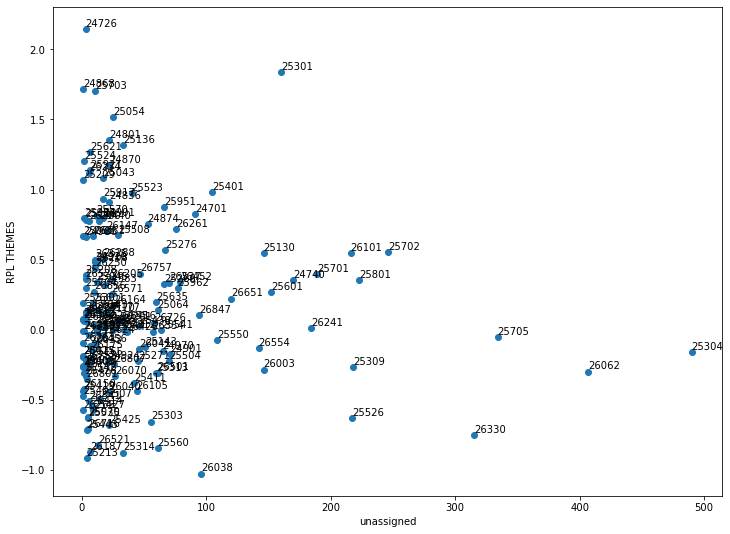

In [ ]:
svi_unassigned = wv_lp[2].join(svi_zips.set_index(['ZIP']), on='RATES ZIP', how='left')
plt.figure(figsize=(12,9))

plt.scatter(svi_unassigned['picked'], svi_unassigned['RPL_THEMES'])
plt.xlabel('unassigned')
plt.ylabel('RPL THEMES')

labels = svi_unassigned.index
for i, label in enumerate(labels):
    plt.text(svi_unassigned['picked'][i], svi_unassigned['RPL_THEMES'][i]+.02, labels[i])


plt.show()

# print(svi_unassigned[RP])

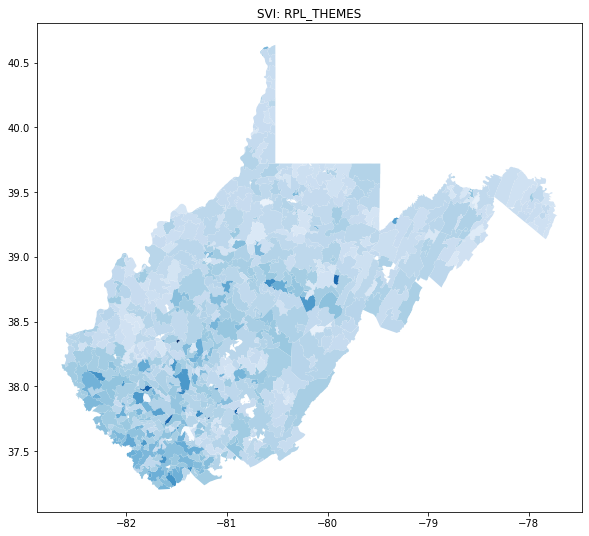

In [ ]:
wv_svi_geo = f1.filter_out_states(svi_geo, state, True)
wv_svi_geo.plot(figsize=(12,9), column='RPL_THEMES', cmap='Blues')

plt.title('SVI: RPL_THEMES')
plt.show()

# Pennsylvania

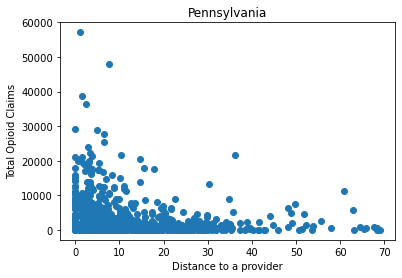

c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:313: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return provider_with_geo['geometry'].centroid


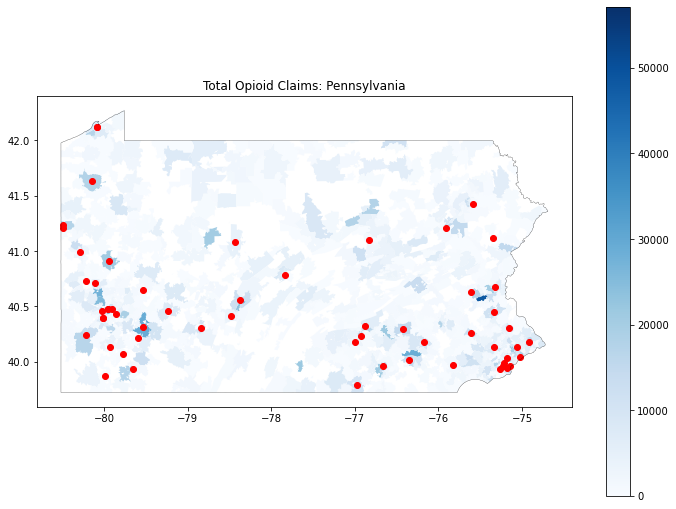

c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\func1.py:313: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return provider_with_geo['geometry'].centroid


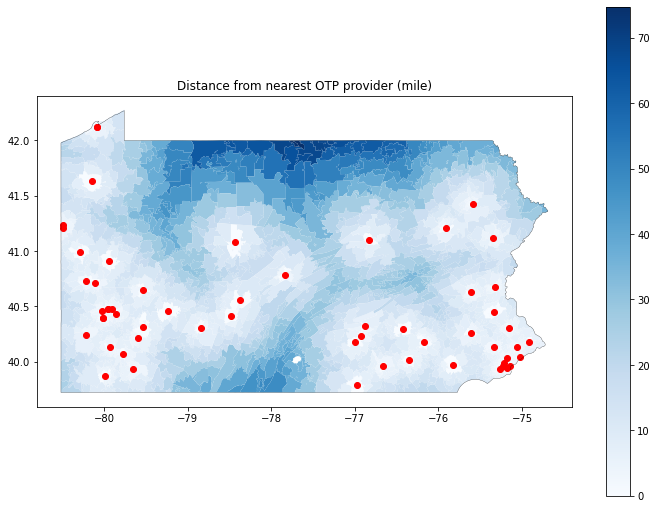

c:\Users\kcall\Miniconda3\lib\site-packages\geopandas\geodataframe.py:1350: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")
c:\Users\kcall\OneDrive - Gainwell Technologies\Documents\Underserved_otp\src\linear_program.py:145: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: ESRI:102008
Right CRS: None

  distances = gpd.GeoSeries(merged['RATES CENTERS']).distance(gpd.GeoSeries(merged['PROVIDER CENTERS']), align=False)


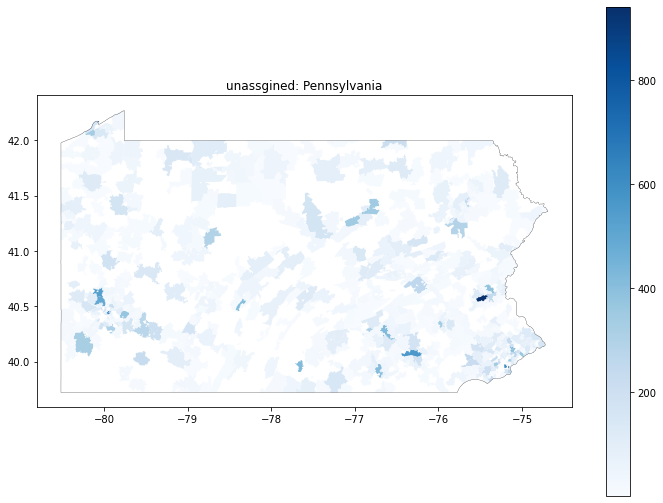

In [27]:
state = 'Pennsylvania'
f1.distance_scatter_plot(zip_geo_data, provider_data, year_rates_data, state)
f1.plot_rates(states_geo_data, zip_geo_data, year_rates_data, provider_data, 'Tot_Opioid_Clms', state)
f1.plot_dist_to_providers(zip_geo_data, states_geo_data, provider_data, state)
penn_lp = lp.run_model(provider_data, zip_geo_data, year_rates_data, state, DIST_THRESH, True)

In [37]:
top_unassigned = penn_lp[1].sort_values('picked', ascending=False).reset_index(level=[1])
print(top_unassigned['picked'][:5])

RATES ZIP
19107    941.0
18103    934.0
15213    706.0
19104    590.0
17601    561.0
Name: picked, dtype: float64


zip code 19107 is located in Philidelphia 

zip code 18103 is located in Allentown 

zip code 15213 is located in Pittsburg 

zip code 19104 is located in Philidelphia 

zip code 17601 is located in Lancaster 


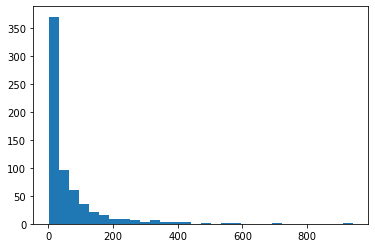

In [ ]:
plt.hist(penn_lp[2]['picked'], bins=30)
plt.show()

In [ ]:
obj, merged, unassign = penn_lp
num_top = 65
pd.set_option('display.max_columns', 100)
unassign = unassign.sort_values(by=['picked'])

top_10 = unassign.iloc[-num_top:]
bottom_10 = unassign.iloc[:num_top]


Index(['Tot_Opioid_Prscrbrs', 'Tot_Opioid_Clms', 'MedPop',
       'Estimate_Need_Care', 'GEOID20', 'CLASSFP20', 'MTFCC20', 'FUNCSTAT20',
       'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20', 'rates geometry',
       'RATES CENTERS', 'const', 'PROVIDER NAME', 'PROVIDER ADDRESS LINE 1',
       'PROVIDER ADDRESS LINE 2', 'PROVIDER CITY', 'PROVIDER STATE',
       'PROVIDER CAPACITY', 'provider geometry', 'PROVIDER CENTERS',
       'NUM PROVIDERS', 'dist', 'picked'],
      dtype='object')
652
65
65


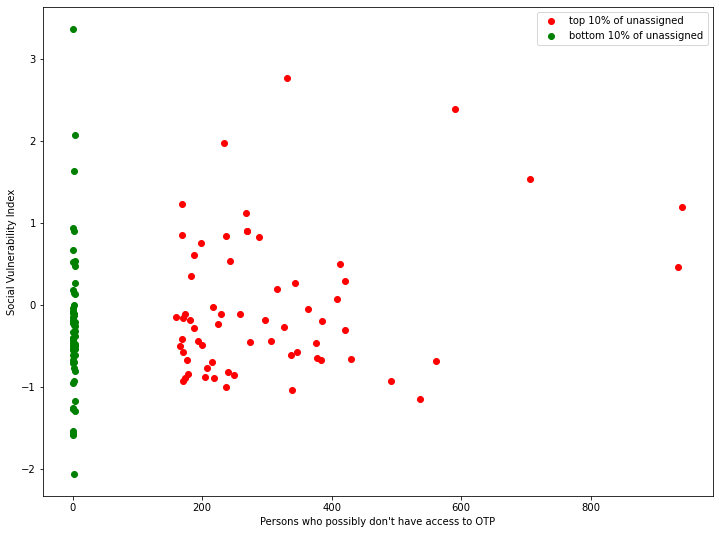

In [ ]:
top_svi = top_10.join(svi_zips.set_index(['ZIP']), on='RATES ZIP', how='left')
bottom_svi = bottom_10.join(svi_zips.set_index(['ZIP']), on='RATES ZIP', how='left')
plt.figure(figsize=(12,9))
plt.scatter(top_svi['picked'], top_svi['RPL_THEMES'], color='red', label='top 10% of unassigned')
plt.xlabel("Persons who possibly don't have access to OTP")
plt.ylabel('Social Vulnerability Index')


# labels = top_svi.index
# for i, label in enumerate(labels):
#     plt.text(top_svi['picked'][i], top_svi['RPL_THEMES'][i]+.02, labels[i])

# labels = bottom_svi.index
# for i, label in enumerate(labels):
#     plt.text(bottom_svi['picked'][i], bottom_svi['RPL_THEMES'][i]+.02, labels[i])



plt.scatter(bottom_svi['picked'], bottom_svi['RPL_THEMES'], color='green', label='bottom 10% of unassigned')

plt.legend()
plt.show()

posx and posy should be finite values
posx and posy should be finite values


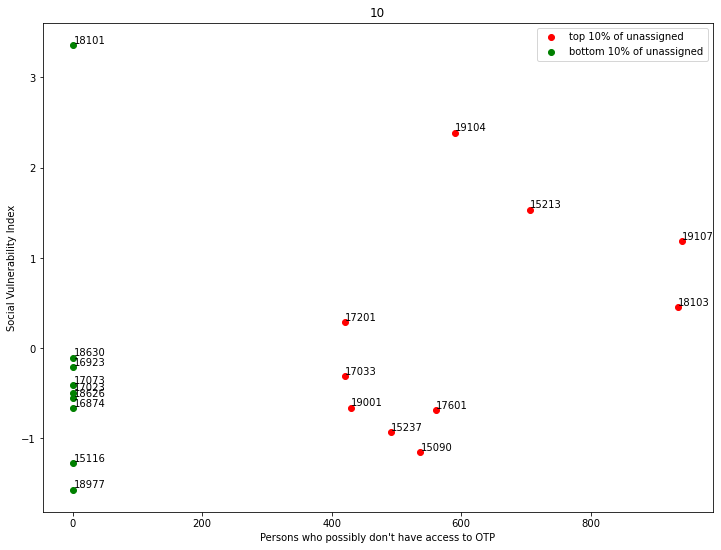

In [ ]:
num_top = 10

obj, merged, unassign = penn_lp
pd.set_option('display.max_columns', 100)
unassign = unassign.sort_values(by=['picked'])

top_10 = unassign.iloc[-num_top:]
bottom_10 = unassign.iloc[:num_top]
top_svi = top_10.join(svi_zips.set_index(['ZIP']), on='RATES ZIP', how='left')
bottom_svi = bottom_10.join(svi_zips.set_index(['ZIP']), on='RATES ZIP', how='left')
plt.figure(figsize=(12,9))
plt.scatter(top_svi['picked'], top_svi['RPL_THEMES'], color='red', label='top 10% of unassigned')
plt.xlabel("Persons who possibly don't have access to OTP")
plt.ylabel('Social Vulnerability Index')


labels = top_svi.index
for i, label in enumerate(labels):
    plt.text(top_svi['picked'][i], top_svi['RPL_THEMES'][i]+.02, labels[i])

labels = bottom_svi.index
for i, label in enumerate(labels):
    plt.text(bottom_svi['picked'][i], bottom_svi['RPL_THEMES'][i]+.02, labels[i])



plt.scatter(bottom_svi['picked'], bottom_svi['RPL_THEMES'], color='green', label='bottom 10% of unassigned')
plt.title(num_top)
plt.legend()
plt.show()

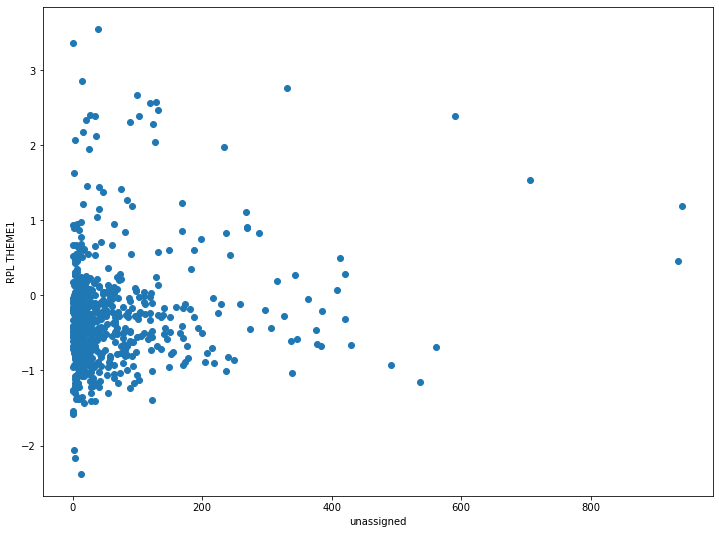

In [ ]:
svi_unassigned = penn_lp[2].join(svi_zips.set_index(['ZIP']), on='RATES ZIP', how='left')

plt.figure(figsize=(12,9))
plt.scatter(svi_unassigned['picked'], svi_unassigned['RPL_THEMES'])
plt.xlabel('unassigned')
plt.ylabel('RPL THEME1')


# labels = svi_unassigned.index
# for i, label in enumerate(labels):
#     plt.text(svi_unassigned['picked'][i], svi_unassigned['RPL_THEMES'][i]+.02, labels[i])


plt.show()

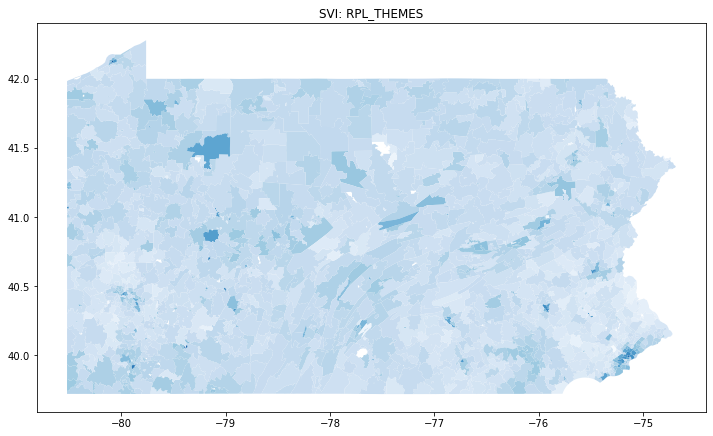

In [ ]:
wv_svi_geo = f1.filter_out_states(svi_geo, state, True)
wv_svi_geo.plot(figsize=(12,9), column='RPL_THEMES', cmap='Blues')

plt.title('SVI: RPL_THEMES')
plt.show()

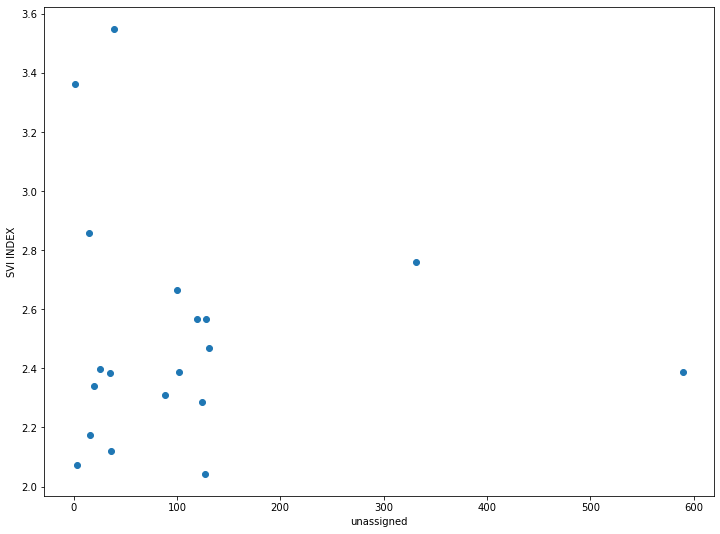

In [ ]:
over_2 = svi_zips[svi_zips['RPL_THEMES'] >= 2]



over_2_unassigned = penn_lp[2].join(over_2.set_index(['ZIP']), on='RATES ZIP', how='right')

plt.figure(figsize=(12,9))
plt.scatter(over_2_unassigned['picked'], over_2_unassigned['RPL_THEMES'])
plt.xlabel('unassigned')
plt.ylabel('SVI INDEX')


# labels = svi_unassigned.index
# for i, label in enumerate(labels):
#     plt.text(svi_unassigned['picked'][i], svi_unassigned['RPL_THEMES'][i]+.02, labels[i])


plt.show()

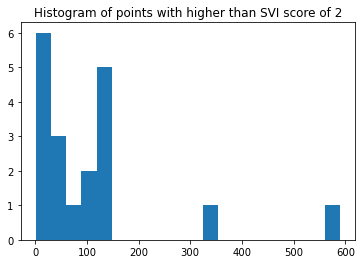

In [ ]:
plt.hist(over_2_unassigned['picked'], bins=20)
plt.title('Histogram of points with higher than SVI score of 2')
plt.show()

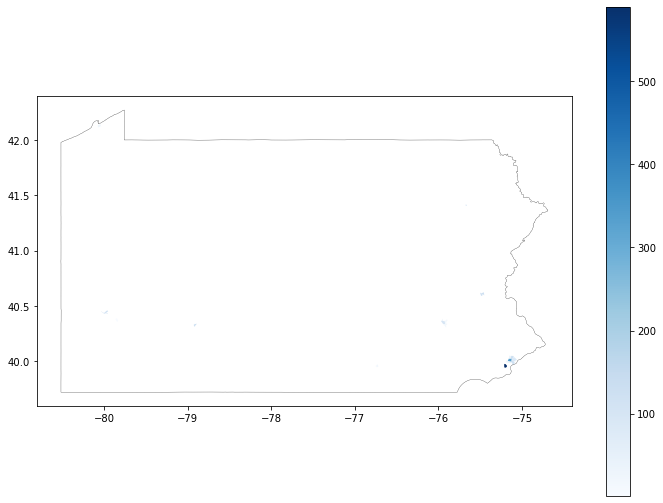

In [ ]:
#Geo over 2 heat map
state_boundary_map = f1.filter_out_states(states_geo_data, state, False).boundary.plot(figsize=(12,9), color='Black', linewidth=.25)
# f1.filter_out_states(zip_geo_data, state, True).boundary.plot(ax=state_boundary_map, color='Black', linewidth=.25, alpha=.3)

over_2_unassigned.plot(ax=state_boundary_map, column='picked', cmap='Blues', legend=True)
plt.show()

In [38]:
#Table zip, unassign, where it is
over_2_unassigned_d = over_2_unassigned.dropna(axis=0, subset=['picked'])
over_2_unassigned_d.sort_values(by=['picked'], ascending=False, inplace=True)
over_2_unassigned_d = over_2_unassigned_d[['picked', 'Tot_Opioid_Clms', 'RPL_THEMES']]
over_2_unassigned_d.rename({'picked':'unassigned'}, axis=1, inplace=True)
over_2_unassigned_d[:5]

NameError: name 'over_2_unassigned' is not defined

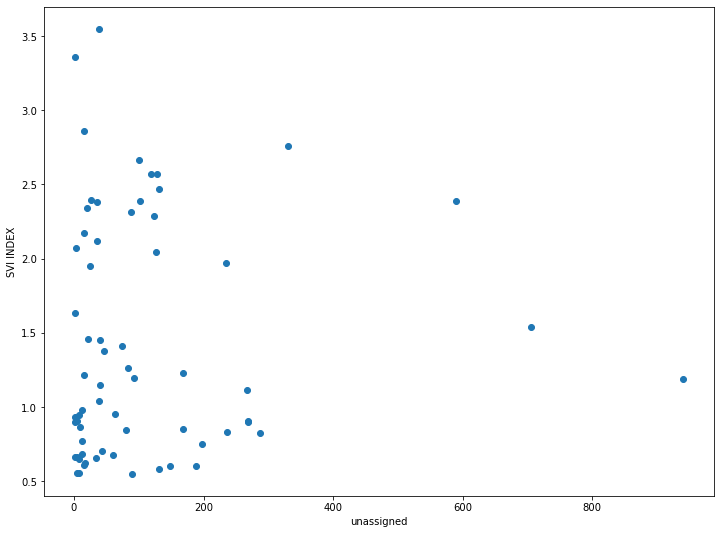

In [ ]:
svi_unassigned = svi_unassigned.sort_values(by=['RPL_THEMES'], ascending=False)
svi_top_10 = svi_unassigned.iloc[:65]

plt.figure(figsize=(12,9))
plt.scatter(svi_top_10['picked'], svi_top_10['RPL_THEMES'])
plt.xlabel('unassigned')
plt.ylabel('SVI INDEX')


# labels = svi_unassigned.index
# for i, label in enumerate(labels):
#     plt.text(svi_unassigned['picked'][i], svi_unassigned['RPL_THEMES'][i]+.02, labels[i])


plt.show()

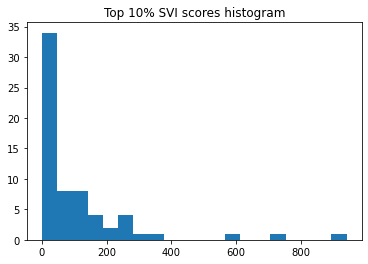

In [ ]:
plt.hist(svi_top_10['picked'], bins=20)
plt.title('Top 10% SVI scores histogram')
plt.show()